<a href="https://colab.research.google.com/github/rezaulcmt/Data_Science_Project_Rezaul/blob/main/Diffensive_Distilations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Diffensive Distilations Restnet18



100%|██████████| 169M/169M [00:13<00:00, 12.6MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
==> Loading teacher model (ResNet18) ..


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


==> Training the teacher model..
==> Generating soft labels..
==> Loading student model (ResNet18) ..
==> Training the student model..


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3369: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1: Loss: 0.000
Epoch 2: Loss: 0.000
==> Evaluating the student model under adversarial attacks..
Accuracy on clean examples: 1.07%
Accuracy on FGSM examples: 0.36%


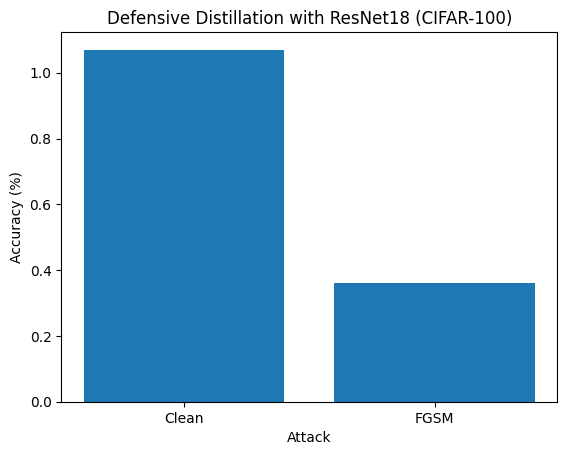

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import models
import random
import matplotlib.pyplot as plt

# Reduce memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Prepare CIFAR-100 data
transform_train = transforms.Compose([
    transforms.Resize(112),  # Smaller image size
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Load teacher model
print('==> Loading teacher model (ResNet18) ..')
teacher_model = models.resnet18(pretrained=False)  # No pretrained weights to save memory
teacher_model.fc = nn.Linear(512, 100)  # Adjust final layer for CIFAR-100
teacher_model = teacher_model.to(device)

# Train the teacher model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

print("==> Training the teacher model..")
for epoch in range(2):  # Reduce epochs for memory constraints
    teacher_model.train()
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()  # Clear memory after every batch

# Generate soft labels with temperature
def generate_soft_labels(model, dataloader, temperature=10):
    soft_labels = []
    model = model.to('cpu')  # Move model to CPU to save GPU memory
    for inputs, targets in dataloader:
        inputs, targets = inputs.to('cpu'), targets.to('cpu')
        with torch.no_grad():
            outputs = model(inputs) / temperature
            soft_labels.append((inputs, torch.softmax(outputs, dim=1)))
    model = model.to(device)  # Return model to GPU after generating labels
    return soft_labels

print("==> Generating soft labels..")
soft_train_labels = generate_soft_labels(teacher_model, trainloader)

# Load student model
print('==> Loading student model (ResNet18) ..')
student_model = models.resnet18(pretrained=False)  # No pretrained weights to save memory
student_model.fc = nn.Linear(512, 100)  # Adjust final layer for CIFAR-100
student_model = student_model.to(device)

optimizer = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Train the student model with soft labels
def train_student(model, soft_labels, temperature=10):
    model.train()
    for epoch in range(2):  # Reduce epochs for memory constraints
        total_loss = 0
        for inputs, soft_targets in soft_labels:
            inputs, soft_targets = inputs.to(device), soft_targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs) / temperature
            loss = nn.KLDivLoss()(torch.log_softmax(outputs, dim=1), soft_targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}: Loss: {total_loss / len(soft_labels):.3f}")

print("==> Training the student model..")
train_student(student_model, soft_train_labels)

# FGSM attack function
def fgsm_attack(model, x, y, epsilon):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    output = model(x_adv)
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

# Evaluate the student model under adversarial attacks
def test_adversarial_defense(model, attack=None, epsilon=None):
    correct = 0
    total = 0
    model.eval()
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if attack == 'FGSM':
            inputs = fgsm_attack(model, inputs, targets, epsilon)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    print(f'Accuracy on {attack if attack else "clean"} examples: {acc:.2f}%')
    return acc

# Parameters for FGSM attack
epsilon_fgsm = 0.1

# Test the student model
print("==> Evaluating the student model under adversarial attacks..")
acc_clean = test_adversarial_defense(student_model)
acc_fgsm = test_adversarial_defense(student_model, attack='FGSM', epsilon=epsilon_fgsm)

# Plot results
attacks = ['Clean', 'FGSM']
accuracies = [acc_clean, acc_fgsm]
plt.bar(attacks, accuracies)
plt.xlabel('Attack')
plt.ylabel('Accuracy (%)')
plt.title('Defensive Distillation with ResNet18 (CIFAR-100)')
plt.show()
